In this exercise we use a **Multilayer Perceptron (MLP)** to model and forecast **NO₂ concentrations** from an urban air-quality time series.

**Methodological goals**

- Learn how to:
  - build an MLP regression model for time series,
  - create **lagged features** and **periodic features** (day, week, year cycles),
  - apply **outlier removal** and **data scaling**,
  - evaluate deep-learning models with appropriate metrics and plots.

**Application goals (air quality)**

- Quantify how well an MLP can reproduce and predict hourly **NO₂** using:
  - past NO₂ values (lags),
  - periodic (seasonal) features,
  - additional meteorological/climate variables.
- Compare the performance of different model configurations and feature sets.
- Relate the results to practical air-quality forecasting and nowcasting.

## Task overview

The notebook is divided into several tasks:

**Task 1 – Basic MLP with NO₂ lag**
- Build an MLP that uses **lagged NO₂** (e.g. 24-hour lag) as input.
- Perform outlier detection, scaling, model training and evaluation.
- Inspect time-series and observed–predicted plots.

**Task 2 – Add periodic features**
- Construct **daily, weekly and yearly** sine–cosine features.
- Train an MLP using ONLY periodic features (and a lagged variable).
- Study how the **MLP architecture** affects performance and training speed.

**Task 3 – Add climate / weather variables**
- Extend the feature set with **meteorological variables** (e.g. temperature, humidity) plus periodic features.
- Explore how adding extra inputs and changing MLP settings influence the results.

**Task 4 – Compare models**
- Compare the MLP models from Tasks 1–3 to the earlier **linear regression with periodic components**.
- Summarise results in a table (e.g. using **index of agreement (IA)** as the main indicator) and discuss which model is most suitable and why.

Upload Dataset

In [ ]:
# With this code you can directly get access to your own disk and upload it to Google Colab
from google.colab import files
import pandas as pd
import io

# 1) Upload the CSV file
uploaded = files.upload()   # Opens a file picker in Colab

# 2) Extract the filename
fname = next(iter(uploaded))

# 3) Load CSV into a pandas DataFrame
df = pd.read_csv(io.BytesIO(uploaded[fname]), sep=';', decimal=',')

# 4) Display the first rows
df.head()
# with following code you get get acees to uploded files in Google colab
#df= pd.read_csv("toolo.csv",  sep=';', decimal=',')

Saving AQdataNumber(AQdata).csv to AQdataNumber(AQdata) (2).csv


,ID,Year,Julianday,Time,NO2,O3,PM10,CO,temperature,humidity,windspeed,sinJD,cosJD,sinTime,cosTime
0,1,1996,1,1,77.0,11.0,23.00,1.5,-5.55,97.0,1.3,0.02,1.0,0.26,0.97
1,2,1996,1,2,71.0,10.0,23.00,1.6,-5.55,97.0,1.3,0.02,1.0,0.50,0.87
2,3,1996,1,3,62.0,8.0,17.33,0.8,-6.05,97.0,1.3,0.02,1.0,0.71,0.71
3,4,1996,1,4,60.5,8.0,17.33,0.7,-6.55,97.0,1.3,0.02,1.0,0.87,0.50
4,5,1996,1,5,59.0,10.0,17.33,0.7,-6.95,97.0,1.3,0.02,1.0,0.97,0.26


Build a proper datetime index (before cell 1)

In [ ]:
df['Standard_Date'] = pd.to_datetime(
    df['Year'].astype(str) + '-' + df['Julianday'].astype(str),
    format='%Y-%j'
)
df['Standard_Date'] = df['Standard_Date'] + pd.to_timedelta(df['Time'], unit='H')
df

/tmp/ipython-input-126866415.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  df['Standard_Date'] = df['Standard_Date'] + pd.to_timedelta(df['Time'], unit='H')


,ID,Year,Julianday,Time,NO2,O3,PM10,CO,temperature,humidity,windspeed,sinJD,cosJD,sinTime,cosTime,Standard_Date
0,1,1996,1,1,77.00,11.00,23.00,1.5,-5.55,97.0,1.30,0.02,1.0,0.26,0.97,1996-01-01 01:00:00
1,2,1996,1,2,71.00,10.00,23.00,1.6,-5.55,97.0,1.30,0.02,1.0,0.50,0.87,1996-01-01 02:00:00
2,3,1996,1,3,62.00,8.00,17.33,0.8,-6.05,97.0,1.30,0.02,1.0,0.71,0.71,1996-01-01 03:00:00
3,4,1996,1,4,60.50,8.00,17.33,0.7,-6.55,97.0,1.30,0.02,1.0,0.87,0.50,1996-01-01 04:00:00
4,5,1996,1,5,59.00,10.00,17.33,0.7,-6.95,97.0,1.30,0.02,1.0,0.97,0.26,1996-01-01 05:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,35060,1999,365,20,24.00,16.00,35.00,0.3,-10.35,91.0,3.71,0.00,1.0,-0.87,0.50,1999-12-31 20:00:00
35060,35061,1999,365,21,27.00,12.00,63.00,0.4,-11.35,89.3,3.47,0.00,1.0,-0.71,0.71,1999-12-31 21:00:00
35061,35062,1999,365,22,20.33,28.67,46.67,0.4,-12.35,87.7,3.22,0.00,1.0,-0.50,0.87,1999-12-31 22:00:00
35062,35063,1999,365,23,13.67,45.33,30.33,0.4,-13.25,86.0,2.97,0.00,1.0,-0.26,0.97,1999-12-31 23:00:00


Import libraries and ML tools

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


Here we set the data table column names and get rid of the measurement that relates to the leap year. That would make each year have the same number of days.

In [ ]:
df_data = df.drop(df[df['Julianday'] == 366].index)
df_data


,ID,Year,Julianday,Time,NO2,O3,PM10,CO,temperature,humidity,windspeed,sinJD,cosJD,sinTime,cosTime,Standard_Date
0,1,1996,1,1,77.00,11.00,23.00,1.5,-5.55,97.0,1.30,0.02,1.0,0.26,0.97,1996-01-01 01:00:00
1,2,1996,1,2,71.00,10.00,23.00,1.6,-5.55,97.0,1.30,0.02,1.0,0.50,0.87,1996-01-01 02:00:00
2,3,1996,1,3,62.00,8.00,17.33,0.8,-6.05,97.0,1.30,0.02,1.0,0.71,0.71,1996-01-01 03:00:00
3,4,1996,1,4,60.50,8.00,17.33,0.7,-6.55,97.0,1.30,0.02,1.0,0.87,0.50,1996-01-01 04:00:00
4,5,1996,1,5,59.00,10.00,17.33,0.7,-6.95,97.0,1.30,0.02,1.0,0.97,0.26,1996-01-01 05:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,35060,1999,365,20,24.00,16.00,35.00,0.3,-10.35,91.0,3.71,0.00,1.0,-0.87,0.50,1999-12-31 20:00:00
35060,35061,1999,365,21,27.00,12.00,63.00,0.4,-11.35,89.3,3.47,0.00,1.0,-0.71,0.71,1999-12-31 21:00:00
35061,35062,1999,365,22,20.33,28.67,46.67,0.4,-12.35,87.7,3.22,0.00,1.0,-0.50,0.87,1999-12-31 22:00:00
35062,35063,1999,365,23,13.67,45.33,30.33,0.4,-13.25,86.0,2.97,0.00,1.0,-0.26,0.97,1999-12-31 23:00:00


Selecting fetures and target coulmn with desired lag times.

In [ ]:

data = df_data.copy()

FEATURE_COLUMNS = [

    # Put your column names here
]
TARGET_COLUMN = "NO2"

LAG_SPECS = {
     'NO2': [24]
}


Outlier detection

In [ ]:
OUTLIER_METHOD = "zscore"   # "zscore" or "iqr" or None
ZSCORE_THRESHOLD = 3.0       # Typical: 3.0
IQR_MULTIPLIER = 1.5         # Typical: 1.5

# Corrected definition to ensure OUTLIER_COLUMNS is a flat list of strings
OUTLIER_COLUMNS = list(set(FEATURE_COLUMNS + [TARGET_COLUMN]))

MLP architecture and training hyperparameters

In [ ]:
MLP_PARAMS = {
    "hidden_layer_sizes": (4),  # e.g., (64, 64), (128, 64, 32)
    "activation": "relu",             # 'identity', 'logistic', 'tanh', 'relu'
    "solver": "adam",                 # 'sgd', 'adam', 'lbfgs'
    "alpha": 1e-4,                    # L2 regularization
    "learning_rate_init": 1e-3,       # initial learning rate
    "learning_rate": "adaptive",      # 'constant', 'invscaling', 'adaptive' (ignored by 'adam' except 'invscaling')
    "power_t": 0.5,                   # used w/ 'invscaling'
    "max_iter": 1000,
    "shuffle": False,                 # keep time order
    "random_state": 42,
    "early_stopping": True,           # uses 10% of training as validation internally
    #"validation_fraction": 0.1,
    "beta_1": 0.9,                    # adam only
    "beta_2": 0.999,                  # adam only
    "epsilon": 1e-8,                  # adam only
    "momentum": 0.9,                  # sgd only
    "nesterovs_momentum": True,       # sgd only
    "verbose": False,
}


Define evaluation metrics

In [ ]:
def calc_r_squared(predicted, observed):
    rss = np.sum((predicted - observed) ** 2)
    tss = np.sum((observed - np.mean(observed)) ** 2)
    return 1 - rss / tss if tss != 0 else np.nan

def index_agreement(s, o):
    numerator = np.sum((o - s) ** 2)
    denominator = np.sum((np.abs(s - np.mean(o)) + np.abs(o - np.mean(o))) ** 2)
    return 1 - numerator / denominator if denominator != 0 else np.nan

def calc_rmse(predicted, observed):
    return float(np.sqrt(np.mean((predicted - observed) ** 2)))

def calc_pse(predicted, observed):
    rmse = calc_rmse(predicted, observed)
    # Linear model (predicted vs observed), then compute RMSE of fitted line
    lm = np.poly1d(np.polyfit(observed, predicted, 1))
    lm_residual = lm(observed)
    lm_rmse = calc_rmse(lm_residual, observed)
    return (lm_rmse ** 2) / (rmse ** 2) if rmse != 0 else np.nan


Build lagged dataset and remove outliers

In [ ]:
LAG_SPECS = {
     'NO2': [24]
}
USE_TIME_BASED_SHIFT = False # Assuming a default, as it's not defined elsewhere in the provided cells.

lagged = data.copy()
for col, lags in LAG_SPECS.items():
    if col not in lagged.columns:
        raise ValueError(f"Column '{col}' for lagging not found in dataframe.")
    for h in lags:
        if USE_TIME_BASED_SHIFT:
            lagged[f"{col}_lag_{h}h"] = lagged[col].shift(freq=f"{h}H")
        else:
            lagged[f"{col}_lag_{h}h"] = lagged[col].shift(h)

# Build final feature set
lag_feature_cols = [f"{col}_lag_{h}h" for col, lags in LAG_SPECS.items() for h in lags]
ALL_FEATURES = FEATURE_COLUMNS + lag_feature_cols

# Drop rows with NaNs introduced by lagging
lagged = lagged.dropna(subset=ALL_FEATURES + [TARGET_COLUMN]).copy()

# ---------------------------------------
# Outlier removal
# ---------------------------------------
def remove_outliers(df, cols, method="zscore", zthr=3.0, iqr_k=1.5):
    if (cols is None) or (len(cols) == 0):
        return df
    mask = pd.Series(True, index=df.index)
    if method is None:
        return df

    if method.lower() == "zscore":
        sub = df[cols].astype(float)
        mu = sub.mean()
        sd = sub.std().replace(0, np.nan)
        z = (sub - mu) / sd
        keep = (z.abs() <= zthr).all(axis=1)
        mask &= keep

    elif method.lower() == "iqr":
        sub = df[cols].astype(float)
        Q1 = sub.quantile(0.25)
        Q3 = sub.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - iqr_k * IQR
        upper = Q3 + iqr_k * IQR
        within = ((sub >= lower) & (sub <= upper)).all(axis=1)
        mask &= within

    else:
        raise ValueError("OUTLIER_METHOD must be 'zscore', 'iqr', or None.")

    return df.loc[mask].copy()

if OUTLIER_COLUMNS is None:
    OUTLIER_COLUMNS = list(set(ALL_FEATURES + [TARGET_COLUMN]))

clean = remove_outliers(
    lagged,
    cols=OUTLIER_COLUMNS,
    method=OUTLIER_METHOD,
    zthr=ZSCORE_THRESHOLD,
    iqr_k=IQR_MULTIPLIER
)

Train–test split

In [ ]:
# Ensure 'Year' exists (derive from Standard_Date if missing)
if 'Year' not in clean.columns:
    clean['Year'] = clean['Standard_Date'].dt.year

# Time-order just in case, then split by year
clean = clean.sort_values('Standard_Date').reset_index(drop=True)

train_df = clean[clean['Year'] != 1999].reset_index(drop=True)
test_df  = clean[clean['Year'] == 1999].reset_index(drop=True)

X_train = train_df[ALL_FEATURES]
y_train = train_df[TARGET_COLUMN].astype(float).values
X_test  = test_df[ALL_FEATURES]
y_test  = test_df[TARGET_COLUMN].astype(float).values

Build pipeline, scale and train MLP

In [ ]:
scaler = StandardScaler()
mlp = MLPRegressor(**MLP_PARAMS)

pipe = Pipeline(steps=[
    ("scaler", scaler),
    ("mlp", mlp)
])

pipe.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPRegressor(early_stopping=True, hidden_layer_sizes=4,
                              learning_rate='adaptive', max_iter=1000,
                              random_state=42, shuffle=False))])

Predict and print metrics

In [ ]:
yhat_train = pipe.predict(X_train)
yhat_test  = pipe.predict(X_test)
def report_metrics(y_true, y_pred, name="Set"):
    r2 = calc_r_squared(y_pred, y_true)
    ia = index_agreement(y_pred, y_true)
    rmse = calc_rmse(y_pred, y_true)
    mae = mean_absolute_error(y_true, y_pred)
    pse = calc_pse(y_pred, y_true)
    print(f"--- {name} ---")
    print(f"R^2:   {r2:.4f}")
    print(f"IA:    {ia:.4f}")
    print(f"RMSE:  {rmse:.4f}")
    print(f"MAE:   {mae:.4f}")
    print(f"PSE:   {pse:.4f}")

report_metrics(y_train, yhat_train, "Train")
report_metrics(y_test, yhat_test, "Test")

--- Train ---
R^2:   0.2742
IA:    0.6502
RMSE:  18.9670
MAE:   15.0531
PSE:   0.7317
--- Test ---
R^2:   0.2657
IA:    0.6457
RMSE:  18.0171
MAE:   14.2944
PSE:   0.7352


Time-series plots

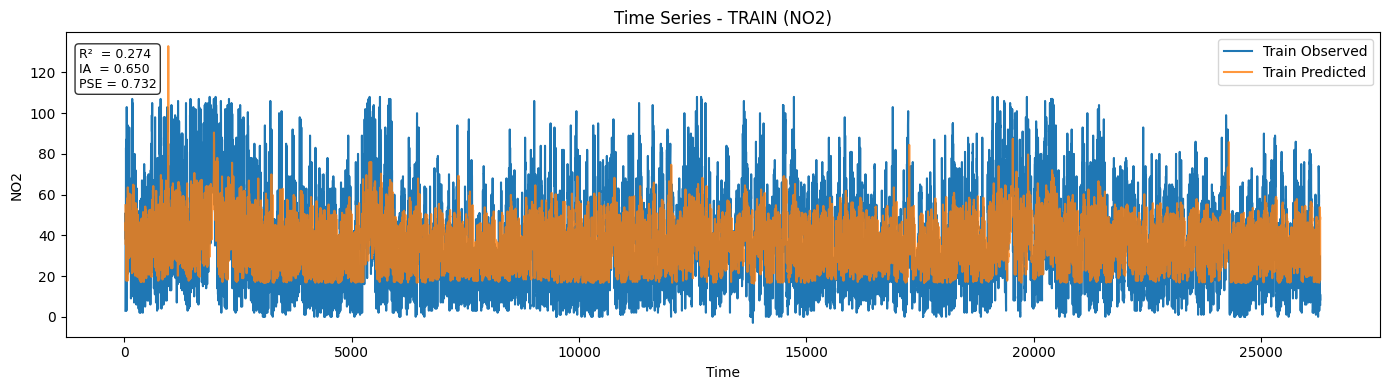

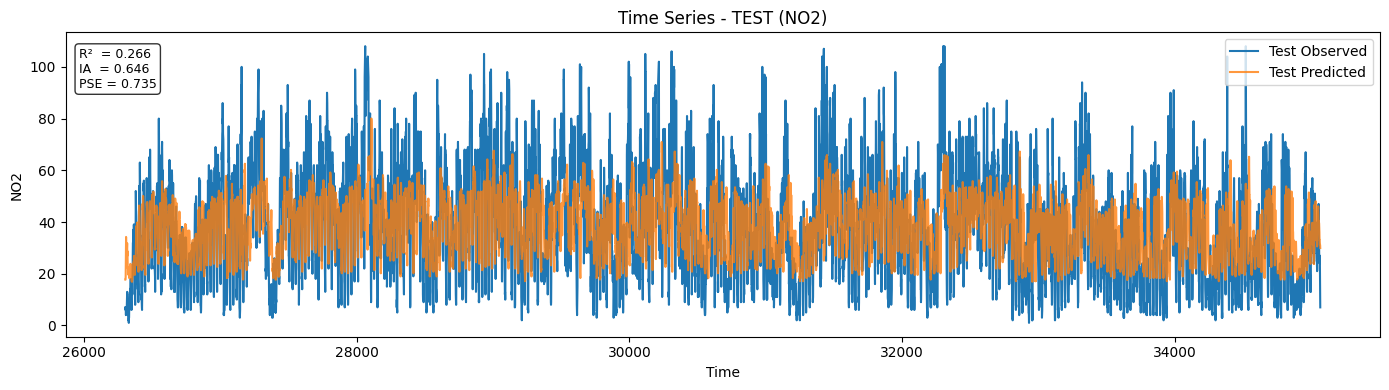

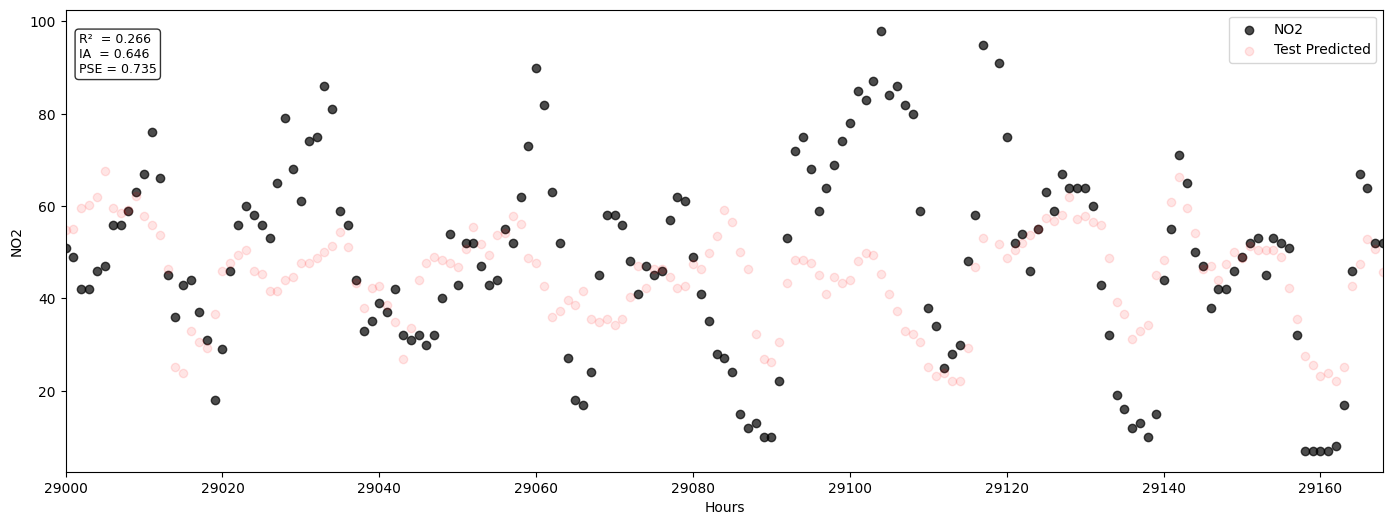

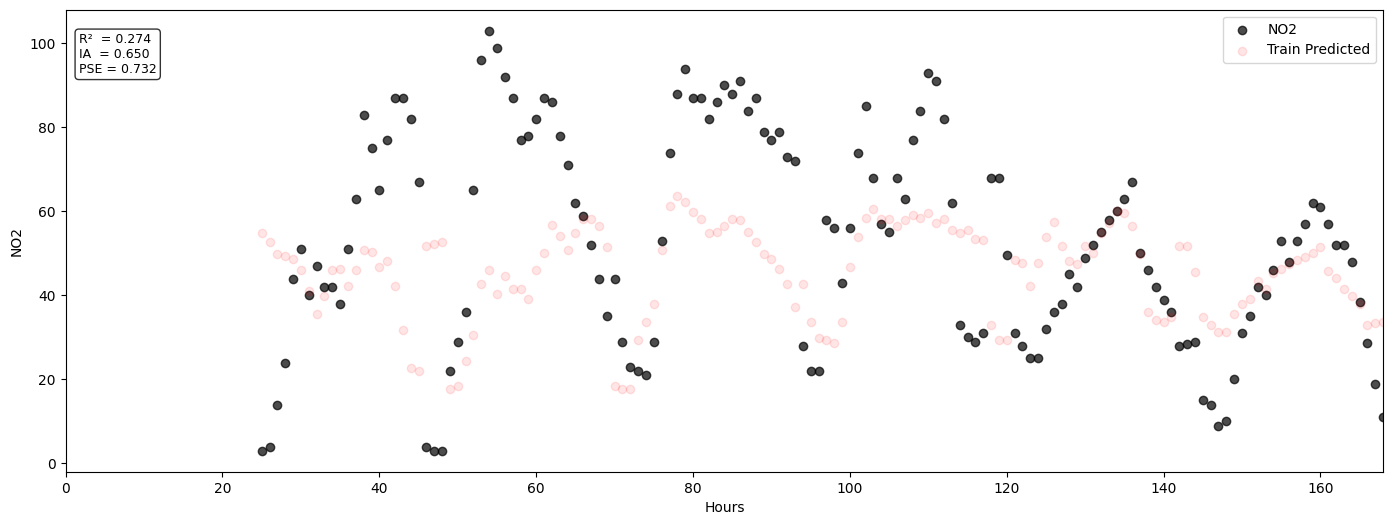

In [ ]:
# ---- compute metrics once ----
r2_train  = calc_r_squared(yhat_train, y_train)
ia_train  = index_agreement(yhat_train, y_train)
pse_train = calc_pse(yhat_train, y_train)

r2_test  = calc_r_squared(yhat_test, y_test)
ia_test  = index_agreement(yhat_test, y_test)
pse_test = calc_pse(yhat_test, y_test)

# ---------- FULL TIME SERIES: TRAIN ----------
plt.figure(figsize=(14,4))
plt.plot(train_df['ID'], y_train, label="Train Observed")
plt.plot(train_df['ID'], yhat_train, label="Train Predicted", alpha=0.8)
plt.title(f"Time Series - TRAIN ({TARGET_COLUMN})")
plt.xlabel("Time")
plt.ylabel(TARGET_COLUMN)
plt.legend()

# add metrics text box (TRAIN)
textstr_train = (
    f"R²  = {r2_train:.3f}\n"
    f"IA  = {ia_train:.3f}\n"
    f"PSE = {pse_train:.3f}"
)
plt.text(
    0.01, 0.95,
    textstr_train,
    transform=plt.gca().transAxes,
    va="top",
    ha="left",
    fontsize=9,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
)

plt.tight_layout()
plt.show()

# ---------- FULL TIME SERIES: TEST ----------
plt.figure(figsize=(14,4))
plt.plot(test_df['ID'], y_test, label="Test Observed")
plt.plot(test_df['ID'], yhat_test, label="Test Predicted", alpha=0.8)
plt.title(f"Time Series - TEST ({TARGET_COLUMN})")
plt.xlabel("Time")
plt.ylabel(TARGET_COLUMN)
plt.legend(loc="upper right")

# add metrics text box (TEST)
textstr_test = (
    f"R²  = {r2_test:.3f}\n"
    f"IA  = {ia_test:.3f}\n"
    f"PSE = {pse_test:.3f}"
)
plt.text(
    0.01, 0.95,
    textstr_test,
    transform=plt.gca().transAxes,
    va="top",
    ha="left",
    fontsize=9,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
)

plt.tight_layout()
plt.show()

# ---------- ZOOMED TEST SCATTER ----------
# Add 'Test Predicted' column to test_df for plotting with df_zoom
test_df['Test Predicted'] = yhat_test

# choose a window on the x-axis to zoom into
xmin, xmax = 29000, 29168   # <- set to the range you want

mask = (test_df['ID'] >= xmin) & (test_df['ID'] <= xmax)
df_zoom = test_df.loc[mask]

plt.figure(figsize=(17, 6))
plt.scatter(df_zoom["ID"], df_zoom["NO2"], color='black', alpha=0.7, label='NO2')
plt.scatter(df_zoom["ID"], df_zoom['Test Predicted'], color='red', alpha=0.1, label='Test Predicted')

plt.xlim(xmin, xmax)
plt.xlabel("Hours")
plt.ylabel("NO2")
plt.legend()

# (optional) show TEST metrics here too
plt.text(
    0.01, 0.95,
    textstr_test,
    transform=plt.gca().transAxes,
    va="top",
    ha="left",
    fontsize=9,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
)

plt.show()

# ---------- ZOOMED TRAIN SCATTER ----------
# Add 'Train Predicted' column to train_df for plotting with df_zoom
train_df['Train Predicted'] = yhat_train

# choose a window on the x-axis to zoom into
xmin, xmax = 0, 168   # <- set to the range you want

mask = (train_df['ID'] >= xmin) & (train_df['ID'] <= xmax)
df_zoom = train_df.loc[mask]

plt.figure(figsize=(17, 6))
plt.scatter(df_zoom["ID"], df_zoom["NO2"], color='black', alpha=0.7, label='NO2')
plt.scatter(df_zoom["ID"], df_zoom['Train Predicted'], color='red', alpha=0.1, label='Train Predicted')

plt.xlim(xmin, xmax)
plt.xlabel("Hours")
plt.ylabel("NO2")
plt.legend()

# (optional) show TRAIN metrics here too
plt.text(
    0.01, 0.95,
    textstr_train,
    transform=plt.gca().transAxes,
    va="top",
    ha="left",
    fontsize=9,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
)

plt.show()


Scatter plots

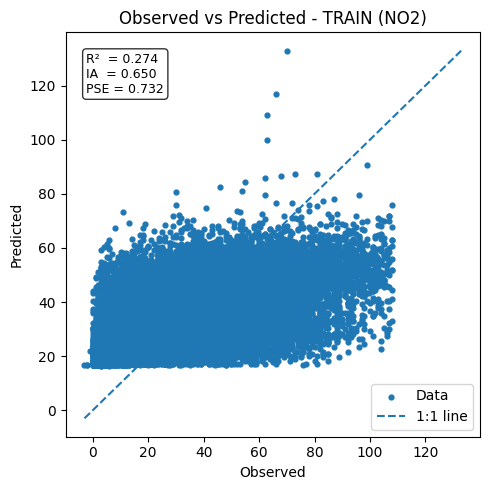

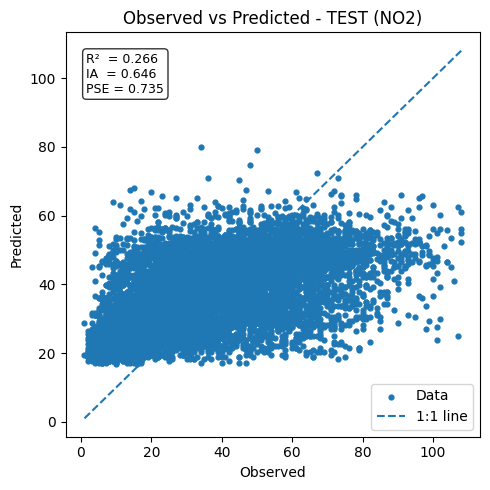

In [ ]:
# Plots: Scatter (train & test)
# ---------------------------------------
# Plots: Scatter (train & test)
# ---------------------------------------
def scatter_obs_pred(y_true, y_pred, title):
    # --- compute performance metrics ---
    r2  = calc_r_squared(y_pred, y_true)
    ia  = index_agreement(y_pred, y_true)
    pse = calc_pse(y_pred, y_true)

    fig, ax = plt.subplots(figsize=(5, 5))

    # scatter points
    ax.scatter(y_true, y_pred, s=12, label="Data")

    # 1:1 line
    xymin = np.nanmin([y_true.min(), y_pred.min()])
    xymax = np.nanmax([y_true.max(), y_pred.max()])
    ax.plot([xymin, xymax], [xymin, xymax], linestyle="--", label="1:1 line")

    ax.set_xlabel("Observed")
    ax.set_ylabel("Predicted")
    ax.set_title(title)

    # --- metrics box inside the figure ---
    textstr = (
        f"R²  = {r2:.3f}\n"
        f"IA  = {ia:.3f}\n"
        f"PSE = {pse:.3f}"
    )

    ax.text(
        0.05, 0.95,
        textstr,
        transform=ax.transAxes,
        va="top",
        ha="left",
        fontsize=9,
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
    )

    ax.legend(loc="lower right")
    fig.tight_layout()
    plt.show()

# calls stay the same
scatter_obs_pred(y_train, yhat_train, f"Observed vs Predicted - TRAIN ({TARGET_COLUMN})")
scatter_obs_pred(y_test,  yhat_test,  f"Observed vs Predicted - TEST ({TARGET_COLUMN})")


Run summary

In [ ]:
print("\n=== RUN SUMMARY ===")
print("Used features:", ALL_FEATURES)
print("Target:", TARGET_COLUMN)
print("Outlier method:", OUTLIER_METHOD)
if OUTLIER_METHOD == "zscore":
    print("  z-threshold:", ZSCORE_THRESHOLD)
elif OUTLIER_METHOD == "iqr":
    print("  IQR multiplier:", IQR_MULTIPLIER)
print("Train size:", len(train_df), "rows")
print("Test size:", len(test_df), "rows")
print("MLP params:", MLP_PARAMS)


=== RUN SUMMARY ===
Used features: ['NO2_lag_24h']
Target: NO2
Outlier method: zscore
  z-threshold: 3.0
Train size: 26059 rows
Test size: 8733 rows
MLP params: {'hidden_layer_sizes': 4, 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'power_t': 0.5, 'max_iter': 1000, 'shuffle': False, 'random_state': 42, 'early_stopping': True, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-08, 'momentum': 0.9, 'nesterovs_momentum': True, 'verbose': False}


In this task we:
- create **periodic (sine–cosine) features** for hour of day, day of week and day of year,
- build an MLP that uses these periodic features (and selected lags) as inputs,
- study how the **number and size of hidden layers** influence:
  - prediction accuracy,
  - training time and stability.

**Quick question for this task:**  
Keep the feature set fixed, but experiment with different `hidden_layer_sizes` and `activation` functions.  
Which combination gives the best balance between good **test IA** and reasonable training time?

In [ ]:
data2 = df_data.copy()
data2

,ID,Year,Julianday,Time,NO2,O3,PM10,CO,temperature,humidity,windspeed,sinJD,cosJD,sinTime,cosTime,Standard_Date
0,1,1996,1,1,77.00,11.00,23.00,1.5,-5.55,97.0,1.30,0.02,1.0,0.26,0.97,1996-01-01 01:00:00
1,2,1996,1,2,71.00,10.00,23.00,1.6,-5.55,97.0,1.30,0.02,1.0,0.50,0.87,1996-01-01 02:00:00
2,3,1996,1,3,62.00,8.00,17.33,0.8,-6.05,97.0,1.30,0.02,1.0,0.71,0.71,1996-01-01 03:00:00
3,4,1996,1,4,60.50,8.00,17.33,0.7,-6.55,97.0,1.30,0.02,1.0,0.87,0.50,1996-01-01 04:00:00
4,5,1996,1,5,59.00,10.00,17.33,0.7,-6.95,97.0,1.30,0.02,1.0,0.97,0.26,1996-01-01 05:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,35060,1999,365,20,24.00,16.00,35.00,0.3,-10.35,91.0,3.71,0.00,1.0,-0.87,0.50,1999-12-31 20:00:00
35060,35061,1999,365,21,27.00,12.00,63.00,0.4,-11.35,89.3,3.47,0.00,1.0,-0.71,0.71,1999-12-31 21:00:00
35061,35062,1999,365,22,20.33,28.67,46.67,0.4,-12.35,87.7,3.22,0.00,1.0,-0.50,0.87,1999-12-31 22:00:00
35062,35063,1999,365,23,13.67,45.33,30.33,0.4,-13.25,86.0,2.97,0.00,1.0,-0.26,0.97,1999-12-31 23:00:00


In [ ]:
# Start from your lagged frame
df_lagged = data2.copy()


df_lagged['Standard_Date'] = pd.to_datetime(df_lagged['Standard_Date'])

# 2) Extract calendar parts
# Hour of day [0..23]
df_lagged['hour'] = df_lagged['Standard_Date'].dt.hour

# Day of week [0=Mon .. 6=Sun]
df_lagged['dow'] = df_lagged['Standard_Date'].dt.dayofweek

# Day of year [1..365/366]
df_lagged['doy'] = df_lagged['Standard_Date'].dt.dayofyear

# Optional: if you still keep a 'Julianday' column and want to be consistent:
# use it instead of computed 'doy'. If present, uncomment:
# df_lagged['doy'] = df_lagged['Julianday'].astype(int)

# 3) Handle leap day to keep yearly period consistent (map 366 -> 365)
df_lagged.loc[df_lagged['doy'] > 365, 'doy'] = 365

# 4) Build continuous time indices (in hours) for each cycle
# Day: 24 hours
day_hours = df_lagged['hour'].astype(float)
day_period = 24.0

# Week: 7 days * 24 hours
week_hours = df_lagged['dow'].astype(float) * 24.0 + df_lagged['hour'].astype(float)
week_period = 7.0 * 24.0

# Year: ~365 days * 24 hours (using mapped DOY in [1..365])
# Convert to 0-based within-year hours: (doy-1)*24 + hour
year_hours = (df_lagged['doy'].astype(float) - 1.0) * 24.0 + df_lagged['hour'].astype(float)
year_period = 365.0 * 24.0

# 5) Cyclical encodings (sin/cos)
two_pi = 2.0 * np.pi

# Day cycle
df_lagged['day_sin']  = np.sin(two_pi * day_hours  / day_period)
df_lagged['day_cos']  = np.cos(two_pi * day_hours  / day_period)

# Week cycle
df_lagged['week_sin'] = np.sin(two_pi * week_hours / week_period)
df_lagged['week_cos'] = np.cos(two_pi * week_hours / week_period)

# Year cycle
df_lagged['year_sin'] = np.sin(two_pi * year_hours / year_period)
df_lagged['year_cos'] = np.cos(two_pi * year_hours / year_period)

# (Optional) Keep your original single-harmonic encodings for reference:
# - They’re basically equivalent to the above but built from discrete
#   Julian day / weekday / hour rather than continuous hour indices.
# Remove old columns if you don’t need them:
for col in ['jd_sin','jd_cos','wd_sin','wd_cos','t_sin','t_cos']:
    if col in df_lagged.columns:
        df_lagged.drop(columns=col, inplace=True)

# Preview the key columns
df_lagged[['Standard_Date','Year','doy','dow','hour',
           'day_sin','day_cos','week_sin','week_cos','year_sin','year_cos']].head()
#df_lagged['Standard_Date'] =  data2 ['windspeed']
df_lagged

,ID,Year,Julianday,Time,NO2,O3,PM10,CO,temperature,humidity,...,Standard_Date,hour,dow,doy,day_sin,day_cos,week_sin,week_cos,year_sin,year_cos
0,1,1996,1,1,77.00,11.00,23.00,1.5,-5.55,97.0,...,1996-01-01 01:00:00,1,0,1,0.258819,0.965926,0.037391,0.999301,0.000717,1.000000
1,2,1996,1,2,71.00,10.00,23.00,1.6,-5.55,97.0,...,1996-01-01 02:00:00,2,0,1,0.500000,0.866025,0.074730,0.997204,0.001435,0.999999
2,3,1996,1,3,62.00,8.00,17.33,0.8,-6.05,97.0,...,1996-01-01 03:00:00,3,0,1,0.707107,0.707107,0.111964,0.993712,0.002152,0.999998
3,4,1996,1,4,60.50,8.00,17.33,0.7,-6.55,97.0,...,1996-01-01 04:00:00,4,0,1,0.866025,0.500000,0.149042,0.988831,0.002869,0.999996
4,5,1996,1,5,59.00,10.00,17.33,0.7,-6.95,97.0,...,1996-01-01 05:00:00,5,0,1,0.965926,0.258819,0.185912,0.982566,0.003586,0.999994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,35060,1999,365,20,24.00,16.00,35.00,0.3,-10.35,91.0,...,1999-12-31 20:00:00,20,4,365,-0.866025,0.500000,-0.930874,-0.365341,-0.002869,0.999996
35060,35061,1999,365,21,27.00,12.00,63.00,0.4,-11.35,89.3,...,1999-12-31 21:00:00,21,4,365,-0.707107,0.707107,-0.943883,-0.330279,-0.002152,0.999998
35061,35062,1999,365,22,20.33,28.67,46.67,0.4,-12.35,87.7,...,1999-12-31 22:00:00,22,4,365,-0.500000,0.866025,-0.955573,-0.294755,-0.001435,0.999999
35062,35063,1999,365,23,13.67,45.33,30.33,0.4,-13.25,86.0,...,1999-12-31 23:00:00,23,4,365,-0.258819,0.965926,-0.965926,-0.258819,-0.000717,1.000000


In [ ]:
# --- CONFIG ---
FEATURE_COLUMNS = [
    'day_sin','day_cos','week_sin','week_cos','year_sin','year_cos'
    # Put ONLY base features here. Do NOT put raw columns you want only as lags.
]
TARGET_COLUMN = "NO2"

# Lags you want to use (ONLY define here)
LAG_SPECS = {
    'windspeed': [24],
    # e.g., 'Temperature': [1, 12, 24],
}

In [ ]:
OUTLIER_METHOD = "zscore"   # "zscore" or "iqr" or None
ZSCORE_THRESHOLD = 3.0       # Typical: 3.0
IQR_MULTIPLIER = 1.5         # Typical: 1.5

# Corrected definition to ensure OUTLIER_COLUMNS is a flat list of strings
OUTLIER_COLUMNS = list(set(FEATURE_COLUMNS + [TARGET_COLUMN]))

In [ ]:
MLP_PARAMS = {
    "hidden_layer_sizes": (4),  # e.g., (64, 64), (128, 64, 32)
    "activation": "relu",             # 'identity', 'logistic', 'tanh', 'relu'
    "solver": "adam",                 # 'sgd', 'adam', 'lbfgs'
    "alpha": 1e-4,                    # L2 regularization
    "learning_rate_init": 1e-3,       # initial learning rate
    "learning_rate": "adaptive",      # 'constant', 'invscaling', 'adaptive' (ignored by 'adam' except 'invscaling')
    "power_t": 0.5,                   # used w/ 'invscaling'
    "max_iter": 1000,
    "shuffle": False,                 # keep time order
    "random_state": 42,
    "early_stopping": True,           # uses 10% of training as validation internally
    #"validation_fraction": 0.1,
    "beta_1": 0.9,                    # adam only
    "beta_2": 0.999,                  # adam only
    "epsilon": 1e-8,                  # adam only
    "momentum": 0.9,                  # sgd only
    "nesterovs_momentum": True,       # sgd only
    "verbose": False,
}

In [ ]:
def calc_r_squared(predicted, observed):
    rss = np.sum((predicted - observed) ** 2)
    tss = np.sum((observed - np.mean(observed)) ** 2)
    return 1 - rss / tss if tss != 0 else np.nan

def index_agreement(s, o):
    numerator = np.sum((o - s) ** 2)
    denominator = np.sum((np.abs(s - np.mean(o)) + np.abs(o - np.mean(o))) ** 2)
    return 1 - numerator / denominator if denominator != 0 else np.nan

def calc_rmse(predicted, observed):
    return float(np.sqrt(np.mean((predicted - observed) ** 2)))

def calc_pse(predicted, observed):
    rmse = calc_rmse(predicted, observed)
    # Linear model (predicted vs observed), then compute RMSE of fitted line
    lm = np.poly1d(np.polyfit(observed, predicted, 1))
    lm_residual = lm(observed)
    lm_rmse = calc_rmse(lm_residual, observed)
    return (lm_rmse ** 2) / (rmse ** 2) if rmse != 0 else np.nan

In [ ]:
USE_TIME_BASED_SHIFT = False

# Optional toggle: keep raw (non-lag) versions of columns that also appear in LAG_SPECS?
INCLUDE_RAW_FOR_LAGGED = False   # False = drop raw if we have lags

# --- BUILD LAGGED DATA ---
lagged = df_lagged.copy()

# Create lag columns
for col, lags in LAG_SPECS.items():
    if col not in lagged.columns:
        raise ValueError(f"Column '{col}' for lagging not found in dataframe.")
    for h in lags:
        if USE_TIME_BASED_SHIFT:
            lagged[f"{col}_lag_{h}h"] = lagged[col].shift(freq=f"{h}H")
        else:
            lagged[f"{col}_lag_{h}h"] = lagged[col].shift(h)

# Collect lag feature names
lag_feature_cols = [f"{col}_lag_{h}h" for col, lags in LAG_SPECS.items() for h in lags]

# Base features:
# - start from FEATURE_COLUMNS
# - optionally drop any raw columns that also appear as keys in LAG_SPECS
if INCLUDE_RAW_FOR_LAGGED:
    base_features = FEATURE_COLUMNS[:]  # keep everything user listed
else:
    base_features = [c for c in FEATURE_COLUMNS if c not in LAG_SPECS.keys()]

# Final feature list = base (no raw for lagged keys if flag=False) + lag columns
ALL_FEATURES = base_features + lag_feature_cols

# Drop rows with NaNs introduced by lagging
lagged = lagged.dropna(subset=ALL_FEATURES + [TARGET_COLUMN]).copy()

# --- OUTLIER REMOVAL (unchanged, but now safe with new ALL_FEATURES) ---
def remove_outliers(df, cols, method="zscore", zthr=3.0, iqr_k=1.5):
    if (cols is None) or (len(cols) == 0):
        return df
    mask = pd.Series(True, index=df.index)
    if method is None:
        return df

    if method.lower() == "zscore":
        sub = df[cols].astype(float)
        mu = sub.mean()
        sd = sub.std().replace(0, np.nan)
        z = (sub - mu) / sd
        keep = (z.abs() <= zthr).all(axis=1)
        mask &= keep

    elif method.lower() == "iqr":
        sub = df[cols].astype(float)
        Q1 = sub.quantile(0.25)
        Q3 = sub.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - iqr_k * IQR
        upper = Q3 + iqr_k * IQR
        within = ((sub >= lower) & (sub <= upper)).all(axis=1)
        mask &= within

    else:
        raise ValueError("OUTLIER_METHOD must be 'zscore', 'iqr', or None.")

    return df.loc[mask].copy()

# If you leave this as None, it will target exactly the used features + target
if 'OUTLIER_COLUMNS' not in globals() or OUTLIER_COLUMNS is None:
    OUTLIER_COLUMNS = list(set(ALL_FEATURES + [TARGET_COLUMN]))

clean = remove_outliers(
    lagged,
    cols=OUTLIER_COLUMNS,
    method=OUTLIER_METHOD,
    zthr=ZSCORE_THRESHOLD,
    iqr_k=IQR_MULTIPLIER
)

In [ ]:
# Ensure 'Year' exists (derive from Standard_Date if missing)
if 'Year' not in clean.columns:
    clean['Year'] = clean['Standard_Date'].dt.year

# Time-order just in case, then split by year
clean = clean.sort_values('Standard_Date').reset_index(drop=True)

train_df = clean[clean['Year'] != 1999].reset_index(drop=True)
test_df  = clean[clean['Year'] == 1999].reset_index(drop=True)

X_train = train_df[ALL_FEATURES]
y_train = train_df[TARGET_COLUMN].astype(float).values
X_test  = test_df[ALL_FEATURES]
y_test  = test_df[TARGET_COLUMN].astype(float).values

In [ ]:
scaler = StandardScaler()
mlp = MLPRegressor(**MLP_PARAMS)

pipe = Pipeline(steps=[
    ("scaler", scaler),
    ("mlp", mlp)
])

pipe.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPRegressor(early_stopping=True, hidden_layer_sizes=4,
                              learning_rate='adaptive', max_iter=1000,
                              random_state=42, shuffle=False))])

In [ ]:
yhat_train = pipe.predict(X_train)
yhat_test  = pipe.predict(X_test)
def report_metrics(y_true, y_pred, name="Set"):
    r2 = calc_r_squared(y_pred, y_true)
    ia = index_agreement(y_pred, y_true)
    rmse = calc_rmse(y_pred, y_true)
    mae = mean_absolute_error(y_true, y_pred)
    pse = calc_pse(y_pred, y_true)
    print(f"--- {name} ---")
    print(f"R^2:   {r2:.4f}")
    print(f"IA:    {ia:.4f}")
    print(f"RMSE:  {rmse:.4f}")
    print(f"MAE:   {mae:.4f}")
    print(f"PSE:   {pse:.4f}")

report_metrics(y_train, yhat_train, "Train")
report_metrics(y_test, yhat_test, "Test")

--- Train ---
R^2:   0.3178
IA:    0.6777
RMSE:  18.3892
MAE:   14.5002
PSE:   0.6959
--- Test ---
R^2:   0.3269
IA:    0.6952
RMSE:  17.2498
MAE:   13.4331
PSE:   0.6577


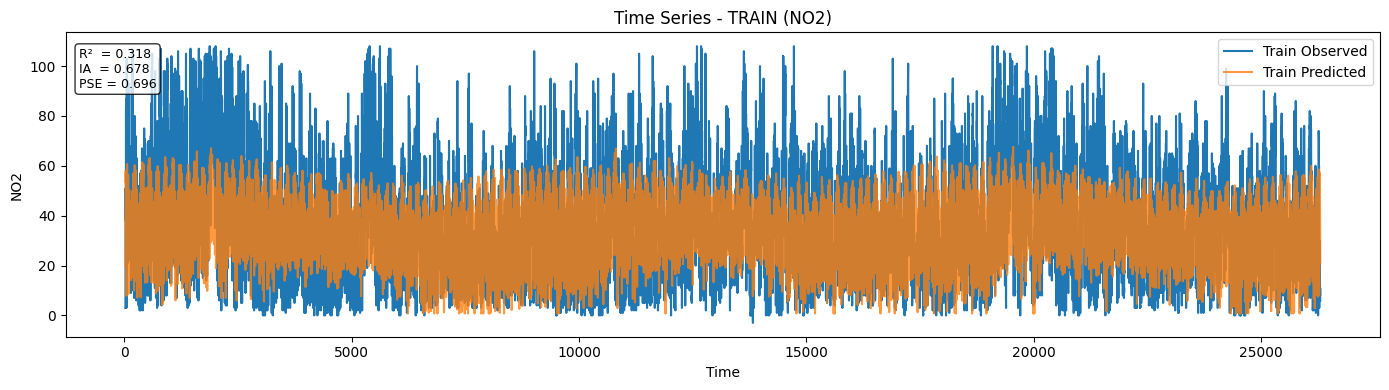

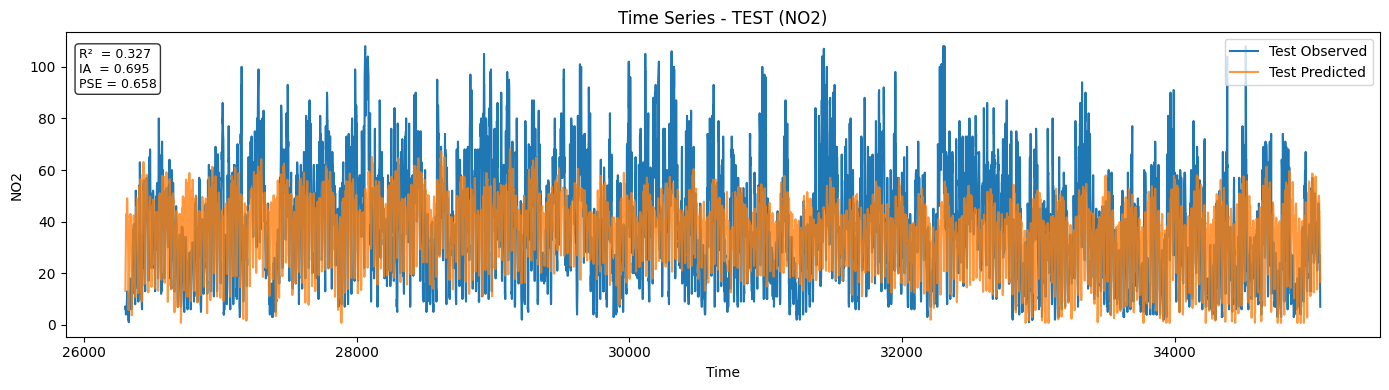

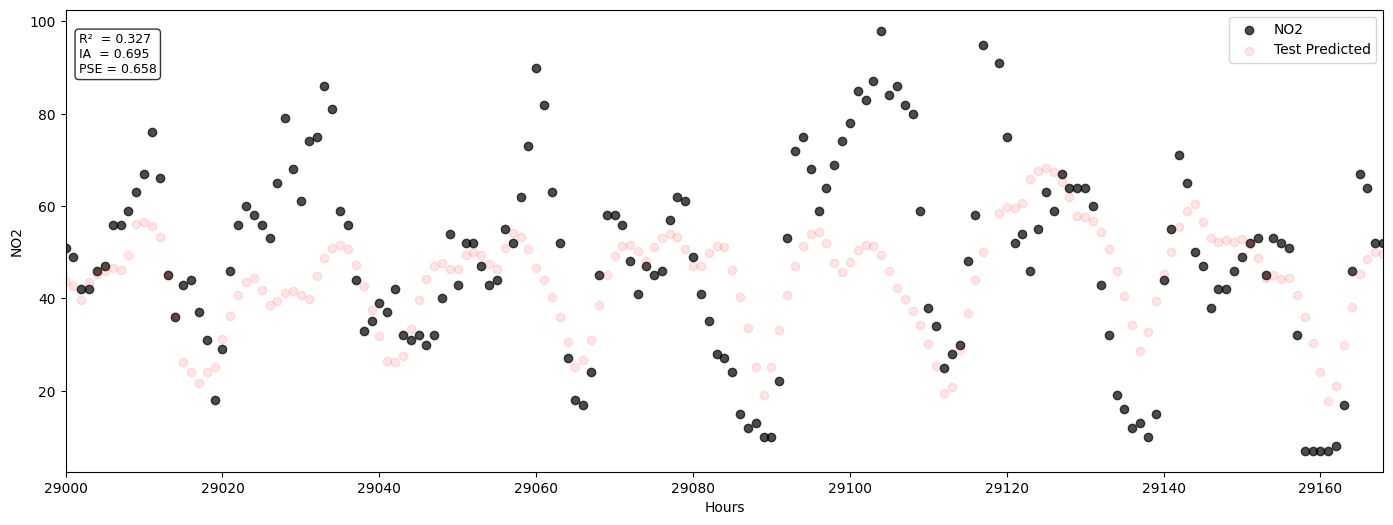

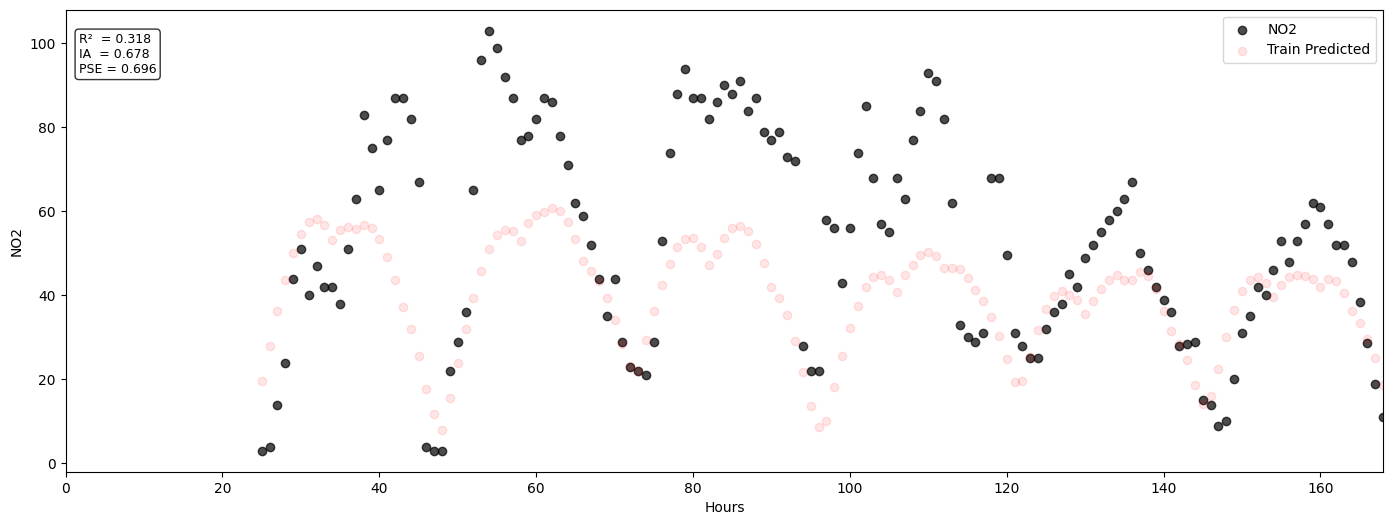

In [ ]:
# ---- compute metrics once ----
r2_train  = calc_r_squared(yhat_train, y_train)
ia_train  = index_agreement(yhat_train, y_train)
pse_train = calc_pse(yhat_train, y_train)

r2_test  = calc_r_squared(yhat_test, y_test)
ia_test  = index_agreement(yhat_test, y_test)
pse_test = calc_pse(yhat_test, y_test)

textstr_train = (
    f"R²  = {r2_train:.3f}\n"
    f"IA  = {ia_train:.3f}\n"
    f"PSE = {pse_train:.3f}"
)

textstr_test = (
    f"R²  = {r2_test:.3f}\n"
    f"IA  = {ia_test:.3f}\n"
    f"PSE = {pse_test:.3f}"
)

# ================== FULL TIME SERIES: TRAIN ==================
plt.figure(figsize=(14,4))
plt.plot(train_df['ID'], y_train, label="Train Observed")
plt.plot(train_df['ID'], yhat_train, label="Train Predicted", alpha=0.8)
plt.title(f"Time Series - TRAIN ({TARGET_COLUMN})")
plt.xlabel("Time")
plt.ylabel(TARGET_COLUMN)
plt.legend()  # keep train legend as before

# metrics box (TRAIN)
plt.text(
    0.01, 0.95,
    textstr_train,
    transform=plt.gca().transAxes,
    va="top",
    ha="left",
    fontsize=9,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
)

plt.tight_layout()
plt.show()

# ================== FULL TIME SERIES: TEST ==================
plt.figure(figsize=(14,4))
plt.plot(test_df['ID'], y_test, label="Test Observed")
plt.plot(test_df['ID'], yhat_test, label="Test Predicted", alpha=0.8)
plt.title(f"Time Series - TEST ({TARGET_COLUMN})")
plt.xlabel("Time")
plt.ylabel(TARGET_COLUMN)
plt.legend(loc="upper right")  # moved to top-right

# metrics box (TEST)
plt.text(
    0.01, 0.95,
    textstr_test,
    transform=plt.gca().transAxes,
    va="top",
    ha="left",
    fontsize=9,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
)

plt.tight_layout()
plt.show()

# ================== ZOOMED TEST SCATTER ==================
# Add 'Test Predicted' column to test_df for plotting with df_zoom
test_df['Test Predicted'] = yhat_test

# choose a window on the x-axis to zoom into
xmin, xmax = 29000, 29168   # <- set to the range you want

mask = (test_df['ID'] >= xmin) & (test_df['ID'] <= xmax)
df_zoom = test_df.loc[mask]

plt.figure(figsize=(17, 6))
plt.scatter(df_zoom["ID"], df_zoom["NO2"], color='black', alpha=0.7, label='NO2')
plt.scatter(df_zoom["ID"], df_zoom['Test Predicted'], color='red', alpha=0.1, label='Test Predicted')

plt.xlim(xmin, xmax)
plt.xlabel("Hours")
plt.ylabel("NO2")
plt.legend(loc="upper right")

# reuse TEST metrics box (same global metrics)
plt.text(
    0.01, 0.95,
    textstr_test,
    transform=plt.gca().transAxes,
    va="top",
    ha="left",
    fontsize=9,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
)

plt.show()

# ================== ZOOMED TRAIN SCATTER ==================
# Add 'Train Predicted' column to train_df for plotting with df_zoom
train_df['Train Predicted'] = yhat_train

# choose a window on the x-axis to zoom into
xmin, xmax = 0, 168   # <- set to the range you want

mask = (train_df['ID'] >= xmin) & (train_df['ID'] <= xmax)
df_zoom = train_df.loc[mask]

plt.figure(figsize=(17, 6))
plt.scatter(df_zoom["ID"], df_zoom["NO2"], color='black', alpha=0.7, label='NO2')
plt.scatter(df_zoom["ID"], df_zoom['Train Predicted'], color='red', alpha=0.1, label='Train Predicted')

plt.xlim(xmin, xmax)
plt.xlabel("Hours")
plt.ylabel("NO2")
plt.legend()  # train zoom legend unchanged

# TRAIN metrics box
plt.text(
    0.01, 0.95,
    textstr_train,
    transform=plt.gca().transAxes,
    va="top",
    ha="left",
    fontsize=9,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
)

plt.show()



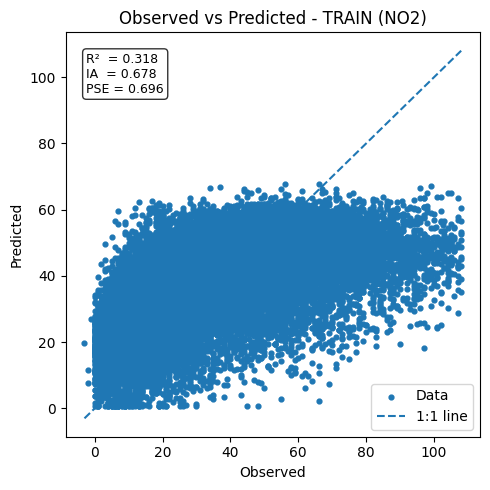

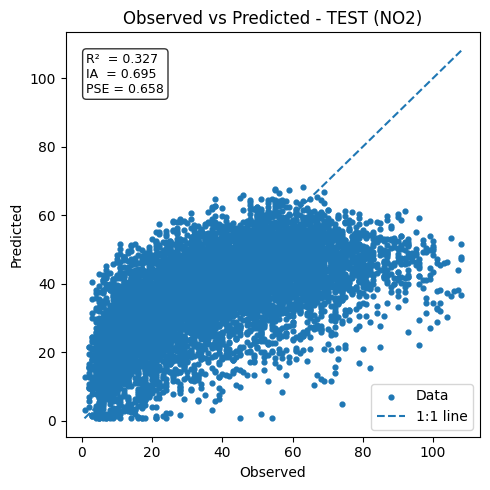

In [ ]:
# Plots: Scatter (train & test)
# ---------------------------------------
# Plots: Scatter (train & test)
# ---------------------------------------
def scatter_obs_pred(y_true, y_pred, title):
    # --- compute performance metrics ---
    r2  = calc_r_squared(y_pred, y_true)
    ia  = index_agreement(y_pred, y_true)
    pse = calc_pse(y_pred, y_true)

    fig, ax = plt.subplots(figsize=(5, 5))

    # scatter points
    ax.scatter(y_true, y_pred, s=12, label="Data")

    # 1:1 line
    xymin = np.nanmin([y_true.min(), y_pred.min()])
    xymax = np.nanmax([y_true.max(), y_pred.max()])
    ax.plot([xymin, xymax], [xymin, xymax], linestyle="--", label="1:1 line")

    ax.set_xlabel("Observed")
    ax.set_ylabel("Predicted")
    ax.set_title(title)

    # --- metrics box inside the figure ---
    textstr = (
        f"R²  = {r2:.3f}\n"
        f"IA  = {ia:.3f}\n"
        f"PSE = {pse:.3f}"
    )

    ax.text(
        0.05, 0.95,
        textstr,
        transform=ax.transAxes,
        va="top",
        ha="left",
        fontsize=9,
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
    )

    ax.legend(loc="lower right")
    fig.tight_layout()
    plt.show()

# calls stay the same
scatter_obs_pred(y_train, yhat_train, f"Observed vs Predicted - TRAIN ({TARGET_COLUMN})")
scatter_obs_pred(y_test,  yhat_test,  f"Observed vs Predicted - TEST ({TARGET_COLUMN})")


In [ ]:
print("\n=== RUN SUMMARY ===")
print("Used features:", ALL_FEATURES)
print("Target:", TARGET_COLUMN)
print("Outlier method:", OUTLIER_METHOD)
if OUTLIER_METHOD == "zscore":
    print("  z-threshold:", ZSCORE_THRESHOLD)
elif OUTLIER_METHOD == "iqr":
    print("  IQR multiplier:", IQR_MULTIPLIER)
print("Train size:", len(train_df), "rows")
print("Test size:", len(test_df), "rows")
print("MLP params:", MLP_PARAMS)


=== RUN SUMMARY ===
Used features: ['day_sin', 'day_cos', 'week_sin', 'week_cos', 'year_sin', 'year_cos', 'windspeed_lag_24h']
Target: NO2
Outlier method: zscore
  z-threshold: 3.0
Train size: 26059 rows
Test size: 8733 rows
MLP params: {'hidden_layer_sizes': 4, 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'power_t': 0.5, 'max_iter': 1000, 'shuffle': False, 'random_state': 42, 'early_stopping': True, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-08, 'momentum': 0.9, 'nesterovs_momentum': True, 'verbose': False}


## Task 3 – Add climate / weather variables to the MLP

Now we extend the model by adding **climate / weather variables** (e.g. temperature, humidity) on top of the periodic features. The aim is to see how additional information helps the MLP to predict NO₂ and how sensitive the model is to architecture choices.

**Quick question for this task:**  
Compare a “small” MLP (few neurons and layers) with a “larger” one when using the extended feature set (periodic + climate variables).  
Does adding climate variables reduce the need for a very complex network, or do you still gain from deeper/wider architectures?


In [ ]:
df_lagged2 = df_lagged.copy()
df_lagged2.columns

Index(['ID', 'Year', 'Julianday', 'Time', 'NO2', 'O3', 'PM10', 'CO',
       'temperature', 'humidity', 'windspeed', 'sinJD', 'cosJD', 'sinTime',
       'cosTime', 'Standard_Date', 'hour', 'dow', 'doy', 'day_sin', 'day_cos',
       'week_sin', 'week_cos', 'year_sin', 'year_cos'],
      dtype='object')

In [ ]:
# --- CONFIG ---
FEATURE_COLUMNS = [
    'day_sin','day_cos','week_sin','week_cos','year_sin','year_cos', 'temperature', 'humidity'
    # Put ONLY base features here. Do NOT put raw columns you want only as lags.
]
TARGET_COLUMN = "NO2"

# Lags you want to use (ONLY define here)
LAG_SPECS = {
    'windspeed': [24],
    # e.g., 'Temperature': [1, 12, 24],
}

In [ ]:
OUTLIER_METHOD = "zscore"   # "zscore" or "iqr" or None
ZSCORE_THRESHOLD = 3.0       # Typical: 3.0
IQR_MULTIPLIER = 1.5         # Typical: 1.5

# Corrected definition to ensure OUTLIER_COLUMNS is a flat list of strings
OUTLIER_COLUMNS = list(set(FEATURE_COLUMNS + [TARGET_COLUMN]))

In [ ]:
MLP_PARAMS = {
    "hidden_layer_sizes": (8,4),  # e.g., (64, 64), (128, 64, 32)
    "activation": "relu",             # 'identity', 'logistic', 'tanh', 'relu'
    "solver": "adam",                 # 'sgd', 'adam', 'lbfgs'
    "alpha": 1e-4,                    # L2 regularization
    "learning_rate_init": 1e-3,       # initial learning rate
    "learning_rate": "adaptive",      # 'constant', 'invscaling', 'adaptive' (ignored by 'adam' except 'invscaling')
    "power_t": 0.5,                   # used w/ 'invscaling'
    "max_iter": 1000,
    "shuffle": False,                 # keep time order
    "random_state": 42,
    "early_stopping": True,           # uses 10% of training as validation internally
    #"validation_fraction": 0.1,
    "beta_1": 0.9,                    # adam only
    "beta_2": 0.999,                  # adam only
    "epsilon": 1e-8,                  # adam only
    "momentum": 0.9,                  # sgd only
    "nesterovs_momentum": True,       # sgd only
    "verbose": False,
}

In [ ]:
def calc_r_squared(predicted, observed):
    rss = np.sum((predicted - observed) ** 2)
    tss = np.sum((observed - np.mean(observed)) ** 2)
    return 1 - rss / tss if tss != 0 else np.nan

def index_agreement(s, o):
    numerator = np.sum((o - s) ** 2)
    denominator = np.sum((np.abs(s - np.mean(o)) + np.abs(o - np.mean(o))) ** 2)
    return 1 - numerator / denominator if denominator != 0 else np.nan

def calc_rmse(predicted, observed):
    return float(np.sqrt(np.mean((predicted - observed) ** 2)))

def calc_pse(predicted, observed):
    rmse = calc_rmse(predicted, observed)
    # Linear model (predicted vs observed), then compute RMSE of fitted line
    lm = np.poly1d(np.polyfit(observed, predicted, 1))
    lm_residual = lm(observed)
    lm_rmse = calc_rmse(lm_residual, observed)
    return (lm_rmse ** 2) / (rmse ** 2) if rmse != 0 else np.nan

In [ ]:
USE_TIME_BASED_SHIFT = False

# Optional toggle: keep raw (non-lag) versions of columns that also appear in LAG_SPECS?
INCLUDE_RAW_FOR_LAGGED = False   # False = drop raw if we have lags

# --- BUILD LAGGED DATA ---
lagged = df_lagged2.copy()

# Create lag columns
for col, lags in LAG_SPECS.items():
    if col not in lagged.columns:
        raise ValueError(f"Column '{col}' for lagging not found in dataframe.")
    for h in lags:
        if USE_TIME_BASED_SHIFT:
            lagged[f"{col}_lag_{h}h"] = lagged[col].shift(freq=f"{h}H")
        else:
            lagged[f"{col}_lag_{h}h"] = lagged[col].shift(h)

# Collect lag feature names
lag_feature_cols = [f"{col}_lag_{h}h" for col, lags in LAG_SPECS.items() for h in lags]

# Base features:
# - start from FEATURE_COLUMNS
# - optionally drop any raw columns that also appear as keys in LAG_SPECS
if INCLUDE_RAW_FOR_LAGGED:
    base_features = FEATURE_COLUMNS[:]  # keep everything user listed
else:
    base_features = [c for c in FEATURE_COLUMNS if c not in LAG_SPECS.keys()]

# Final feature list = base (no raw for lagged keys if flag=False) + lag columns
ALL_FEATURES = base_features + lag_feature_cols

# Drop rows with NaNs introduced by lagging
lagged = lagged.dropna(subset=ALL_FEATURES + [TARGET_COLUMN]).copy()

# --- OUTLIER REMOVAL (unchanged, but now safe with new ALL_FEATURES) ---
def remove_outliers(df, cols, method="zscore", zthr=3.0, iqr_k=1.5):
    if (cols is None) or (len(cols) == 0):
        return df
    mask = pd.Series(True, index=df.index)
    if method is None:
        return df

    if method.lower() == "zscore":
        sub = df[cols].astype(float)
        mu = sub.mean()
        sd = sub.std().replace(0, np.nan)
        z = (sub - mu) / sd
        keep = (z.abs() <= zthr).all(axis=1)
        mask &= keep

    elif method.lower() == "iqr":
        sub = df[cols].astype(float)
        Q1 = sub.quantile(0.25)
        Q3 = sub.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - iqr_k * IQR
        upper = Q3 + iqr_k * IQR
        within = ((sub >= lower) & (sub <= upper)).all(axis=1)
        mask &= within

    else:
        raise ValueError("OUTLIER_METHOD must be 'zscore', 'iqr', or None.")

    return df.loc[mask].copy()

# If you leave this as None, it will target exactly the used features + target
if 'OUTLIER_COLUMNS' not in globals() or OUTLIER_COLUMNS is None:
    OUTLIER_COLUMNS = list(set(ALL_FEATURES + [TARGET_COLUMN]))

clean = remove_outliers(
    lagged,
    cols=OUTLIER_COLUMNS,
    method=OUTLIER_METHOD,
    zthr=ZSCORE_THRESHOLD,
    iqr_k=IQR_MULTIPLIER
)

In [ ]:
# Ensure 'Year' exists (derive from Standard_Date if missing)
if 'Year' not in clean.columns:
    clean['Year'] = clean['Standard_Date'].dt.year

# Time-order just in case, then split by year
clean = clean.sort_values('Standard_Date').reset_index(drop=True)

train_df = clean[clean['Year'] != 1999].reset_index(drop=True)
test_df  = clean[clean['Year'] == 1999].reset_index(drop=True)

X_train = train_df[ALL_FEATURES]
y_train = train_df[TARGET_COLUMN].astype(float).values
X_test  = test_df[ALL_FEATURES]
y_test  = test_df[TARGET_COLUMN].astype(float).values

In [ ]:
scaler = StandardScaler()
mlp = MLPRegressor(**MLP_PARAMS)

pipe = Pipeline(steps=[
    ("scaler", scaler),
    ("mlp", mlp)
])

pipe.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPRegressor(early_stopping=True, hidden_layer_sizes=(8, 4),
                              learning_rate='adaptive', max_iter=1000,
                              random_state=42, shuffle=False))])

In [ ]:
yhat_train = pipe.predict(X_train)
yhat_test  = pipe.predict(X_test)
def report_metrics(y_true, y_pred, name="Set"):
    r2 = calc_r_squared(y_pred, y_true)
    ia = index_agreement(y_pred, y_true)
    rmse = calc_rmse(y_pred, y_true)
    mae = mean_absolute_error(y_true, y_pred)
    pse = calc_pse(y_pred, y_true)
    print(f"--- {name} ---")
    print(f"R^2:   {r2:.4f}")
    print(f"IA:    {ia:.4f}")
    print(f"RMSE:  {rmse:.4f}")
    print(f"MAE:   {mae:.4f}")
    print(f"PSE:   {pse:.4f}")

report_metrics(y_train, yhat_train, "Train")
report_metrics(y_test, yhat_test, "Test")

--- Train ---
R^2:   0.4378
IA:    0.7721
RMSE:  16.6969
MAE:   13.0007
PSE:   0.5683
--- Test ---
R^2:   0.4193
IA:    0.7737
RMSE:  16.0201
MAE:   12.3494
PSE:   0.5146


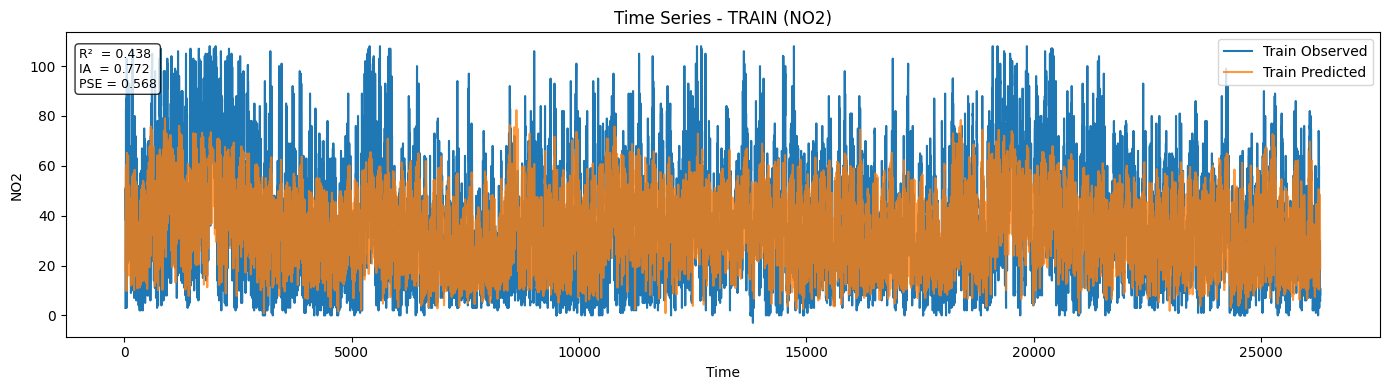

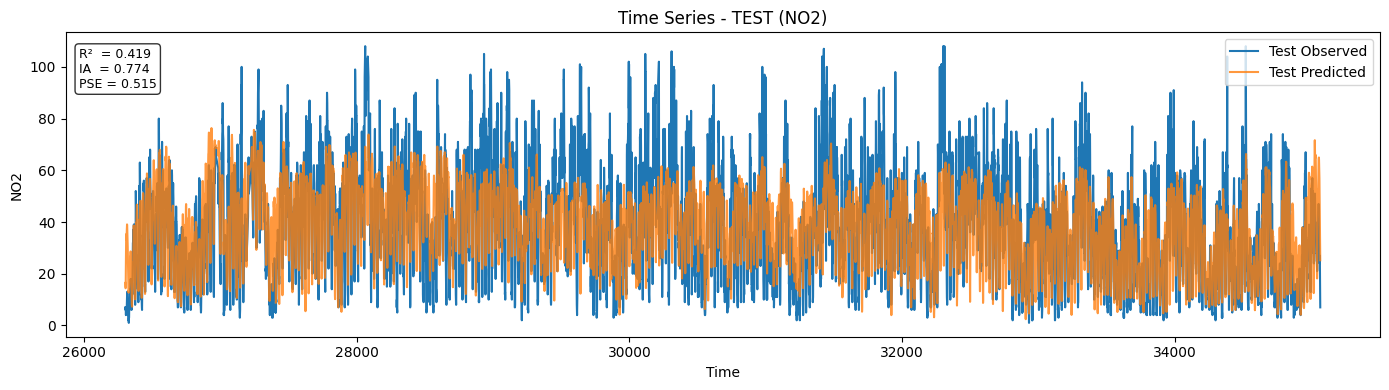

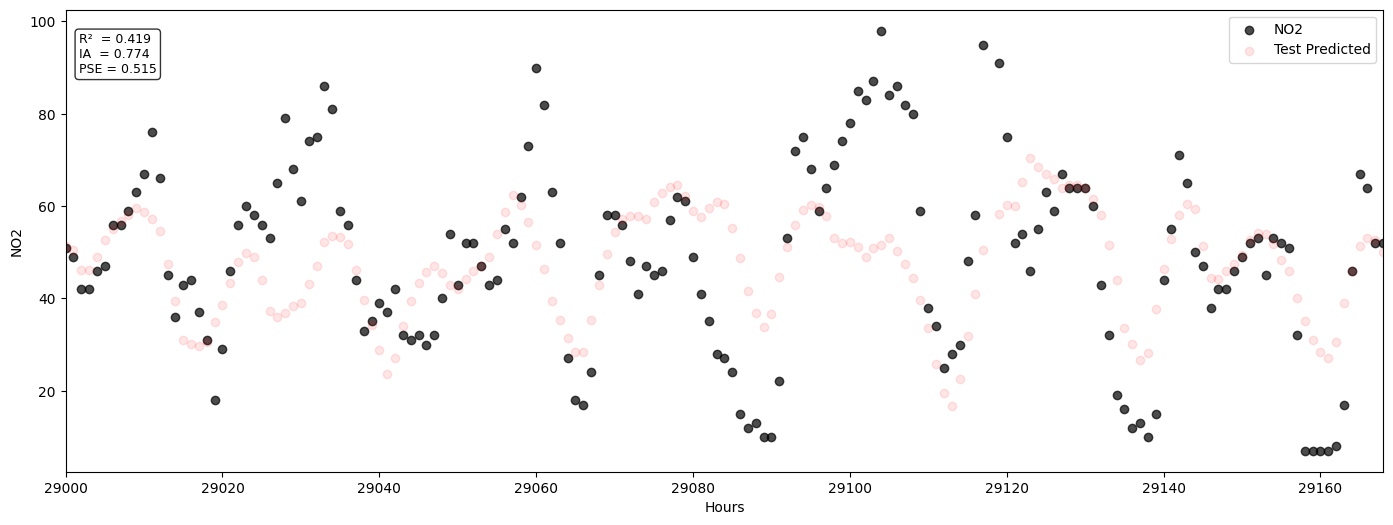

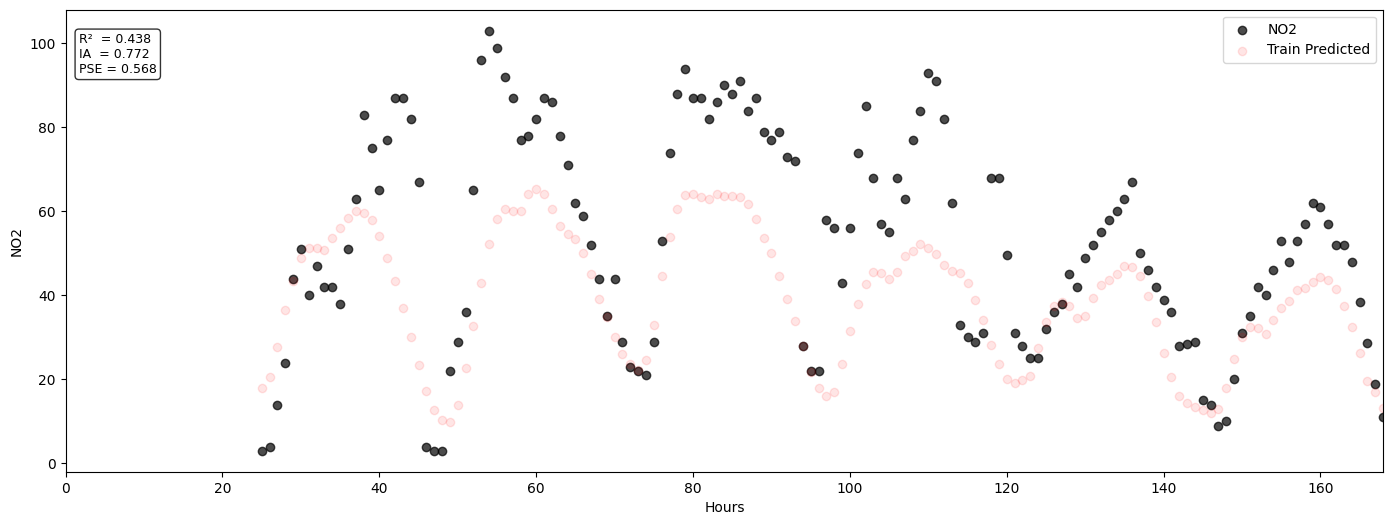

In [ ]:
# ---- compute metrics once ----
r2_train  = calc_r_squared(yhat_train, y_train)
ia_train  = index_agreement(yhat_train, y_train)
pse_train = calc_pse(yhat_train, y_train)

r2_test  = calc_r_squared(yhat_test, y_test)
ia_test  = index_agreement(yhat_test, y_test)
pse_test = calc_pse(yhat_test, y_test)

textstr_train = (
    f"R²  = {r2_train:.3f}\n"
    f"IA  = {ia_train:.3f}\n"
    f"PSE = {pse_train:.3f}"
)

textstr_test = (
    f"R²  = {r2_test:.3f}\n"
    f"IA  = {ia_test:.3f}\n"
    f"PSE = {pse_test:.3f}"
)

# ================== FULL TIME SERIES: TRAIN ==================
plt.figure(figsize=(14,4))
plt.plot(train_df["ID"], y_train, label="Train Observed")
plt.plot(train_df["ID"], yhat_train, label="Train Predicted", alpha=0.8)
plt.title(f"Time Series - TRAIN ({TARGET_COLUMN})")
plt.xlabel("Time")
plt.ylabel(TARGET_COLUMN)
plt.legend()  # train legend stays default

# metrics box (TRAIN)
plt.text(
    0.01, 0.95,
    textstr_train,
    transform=plt.gca().transAxes,
    va="top",
    ha="left",
    fontsize=9,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
)

plt.tight_layout()
plt.show()

# ================== FULL TIME SERIES: TEST ==================
plt.figure(figsize=(14,4))
plt.plot(test_df["ID"], y_test, label="Test Observed")
plt.plot(test_df["ID"], yhat_test, label="Test Predicted", alpha=0.8)
plt.title(f"Time Series - TEST ({TARGET_COLUMN})")
plt.xlabel("Time")
plt.ylabel(TARGET_COLUMN)
plt.legend(loc="upper right")  # moved to top-right

# metrics box (TEST)
plt.text(
    0.01, 0.95,
    textstr_test,
    transform=plt.gca().transAxes,
    va="top",
    ha="left",
    fontsize=9,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
)

plt.tight_layout()
plt.show()

# ================== ZOOMED TEST SCATTER ==================
# Add 'Test Predicted' column to test_df for plotting with df_zoom
test_df["Test Predicted"] = yhat_test

# choose a window on the x-axis to zoom into
xmin, xmax = 29000, 29168   # <- set to the range you want

mask = (test_df["ID"] >= xmin) & (test_df["ID"] <= xmax)
df_zoom = test_df.loc[mask]

plt.figure(figsize=(17, 6))
plt.scatter(df_zoom["ID"], df_zoom["NO2"], color="black", alpha=0.7, label="NO2")
plt.scatter(df_zoom["ID"], df_zoom["Test Predicted"], color="red", alpha=0.1, label="Test Predicted")

plt.xlim(xmin, xmax)
plt.xlabel("Hours")
plt.ylabel("NO2")
plt.legend(loc="upper right")

# reuse TEST metrics box
plt.text(
    0.01, 0.95,
    textstr_test,
    transform=plt.gca().transAxes,
    va="top",
    ha="left",
    fontsize=9,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
)

plt.show()

# ================== ZOOMED TRAIN SCATTER ==================
# Add 'Train Predicted' column to train_df for plotting with df_zoom
train_df["Train Predicted"] = yhat_train

# choose a window on the x-axis to zoom into
xmin, xmax = 0, 168   # <- set to the range you want

mask = (train_df["ID"] >= xmin) & (train_df["ID"] <= xmax)
df_zoom = train_df.loc[mask]

plt.figure(figsize=(17, 6))
plt.scatter(df_zoom["ID"], df_zoom["NO2"], color="black", alpha=0.7, label="NO2")
plt.scatter(df_zoom["ID"], df_zoom["Train Predicted"], color="red", alpha=0.1, label="Train Predicted")

plt.xlim(xmin, xmax)
plt.xlabel("Hours")
plt.ylabel("NO2")
plt.legend()  # train zoom legend default

# TRAIN metrics box
plt.text(
    0.01, 0.95,
    textstr_train,
    transform=plt.gca().transAxes,
    va="top",
    ha="left",
    fontsize=9,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
)

plt.show()


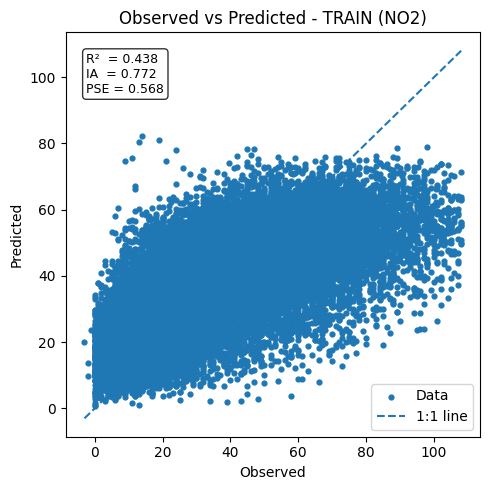

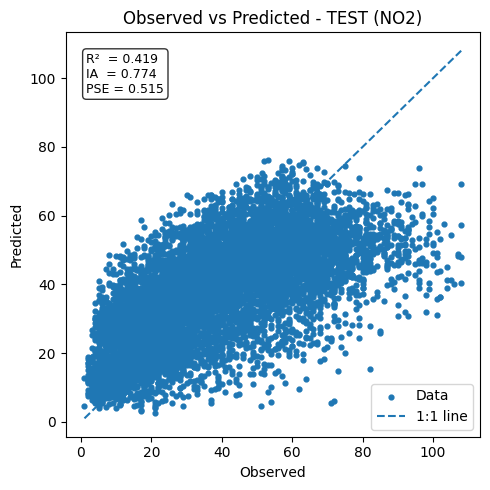

In [ ]:
# Plots: Scatter (train & test)
# ---------------------------------------
def scatter_obs_pred(y_true, y_pred, title):
    # --- compute performance metrics ---
    r2  = calc_r_squared(y_pred, y_true)
    ia  = index_agreement(y_pred, y_true)
    pse = calc_pse(y_pred, y_true)

    fig, ax = plt.subplots(figsize=(5, 5))

    # scatter points
    ax.scatter(y_true, y_pred, s=12, label="Data")

    # 1:1 line
    xymin = np.nanmin([y_true.min(), y_pred.min()])
    xymax = np.nanmax([y_true.max(), y_pred.max()])
    ax.plot([xymin, xymax], [xymin, xymax], linestyle="--", label="1:1 line")

    ax.set_xlabel("Observed")
    ax.set_ylabel("Predicted")
    ax.set_title(title)

    # --- metrics box inside the figure ---
    textstr = (
        f"R²  = {r2:.3f}\n"
        f"IA  = {ia:.3f}\n"
        f"PSE = {pse:.3f}"
    )

    ax.text(
        0.05, 0.95,
        textstr,
        transform=ax.transAxes,
        va="top",
        ha="left",
        fontsize=9,
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
    )

    ax.legend(loc="lower right")
    fig.tight_layout()
    plt.show()

# calls stay the same
scatter_obs_pred(y_train, yhat_train, f"Observed vs Predicted - TRAIN ({TARGET_COLUMN})")
scatter_obs_pred(y_test,  yhat_test,  f"Observed vs Predicted - TEST ({TARGET_COLUMN})")


In [ ]:
print("\n=== RUN SUMMARY ===")
print("Used features:", ALL_FEATURES)
print("Target:", TARGET_COLUMN)
print("Outlier method:", OUTLIER_METHOD)
if OUTLIER_METHOD == "zscore":
    print("  z-threshold:", ZSCORE_THRESHOLD)
elif OUTLIER_METHOD == "iqr":
    print("  IQR multiplier:", IQR_MULTIPLIER)
print("Train size:", len(train_df), "rows")
print("Test size:", len(test_df), "rows")
print("MLP params:", MLP_PARAMS)


=== RUN SUMMARY ===
Used features: ['day_sin', 'day_cos', 'week_sin', 'week_cos', 'year_sin', 'year_cos', 'temperature', 'humidity', 'windspeed_lag_24h']
Target: NO2
Outlier method: zscore
  z-threshold: 3.0
Train size: 26031 rows
Test size: 8680 rows
MLP params: {'hidden_layer_sizes': (8, 4), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'power_t': 0.5, 'max_iter': 1000, 'shuffle': False, 'random_state': 42, 'early_stopping': True, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-08, 'momentum': 0.9, 'nesterovs_momentum': True, 'verbose': False}


Use the results from:
- linear regression with periodic terms (previous exercise) and ARX model,
- Task 1 (MLP with NO₂ lag),
- Task 2 (MLP with periodic features),
- Task 3 (MLP with periodic + climate features),

and summarise them in a **comparison table** using IA (and optionally RMSE, MAE) as the main indicators.

**Quick question:**  
Which model would you recommend for **operational NO₂ forecasting** and why?  
